# Sink-source connectivity for analyzing cognitive state

Applying the sink-source connectivity biomarker for analyzing neural correlates of behavior

# Imports

In [1]:
import h5py 
import mat73
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import mne
import re

# Load Data

In [2]:
subs = ['07']
file_paths = {}

for sub in subs:
    # create a dictionary holding the file paths
    ncsl_share = '/mnt/ncsl_share'
    file_paths[sub] = {
        'setup_path': ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT{sub}/EFRI{sub}_WAR_SES1_Setup.mat',
        'raw_path': ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT{sub}/EFRI{sub}_WAR_SES1_Raw.mat',
        # 'data_path': ncsl_share + f'/Daniel/Data/Trial_by_Chan_by_Freq_by_Time_Snapshots/Subject{sub}_snapshot_normalized.npy', # movement onset as event
        # 'data_path' : ncsl_share + f'/Daniel/Data/Trial_by_Chan_by_Freq_by_Time_Snapshots/show-card_pre-2sec_post-4sec/Subject{sub}_snapshot_normalized.npy', # visual cue as event
    }

In [3]:
raw_file = h5py.File(file_paths[subs[0]]['raw_path'])
setup_data = mat73.loadmat(file_paths[subs[0]]['setup_path'])

In [4]:
event_words = {"fixation": 30,
               "show card": 31,
               "show bet": 32,
               "start move": 35,
               "show card results": 51}

# Apply Sink Source Connectivity

In [5]:
from sink_source import SinkSource

ss = SinkSource(raw_file=raw_file, setup_data=setup_data)

snapshot = ss.get_data(raw_file, event_words["fixation"], [-6,0])

Setting up band-pass filter from 0.5 - 2e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 200.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 59 - 61 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 59.35, 60.65 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 1.2e+02 - 1.2e+02 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 119.20, 120.80 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 1.8e+02 - 1.8e+02 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-ca

In [6]:
snapshot.shape

(162, 75, 3000)

In [16]:
A_hat_all_trials = ss.estimateA_all_trials(snapshot)

0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is computed
0/12 is comput

In [24]:
A_win_all_trials, SI_wins_all_trials, _, _ = ss.computeSS(A_hat_all_trials)

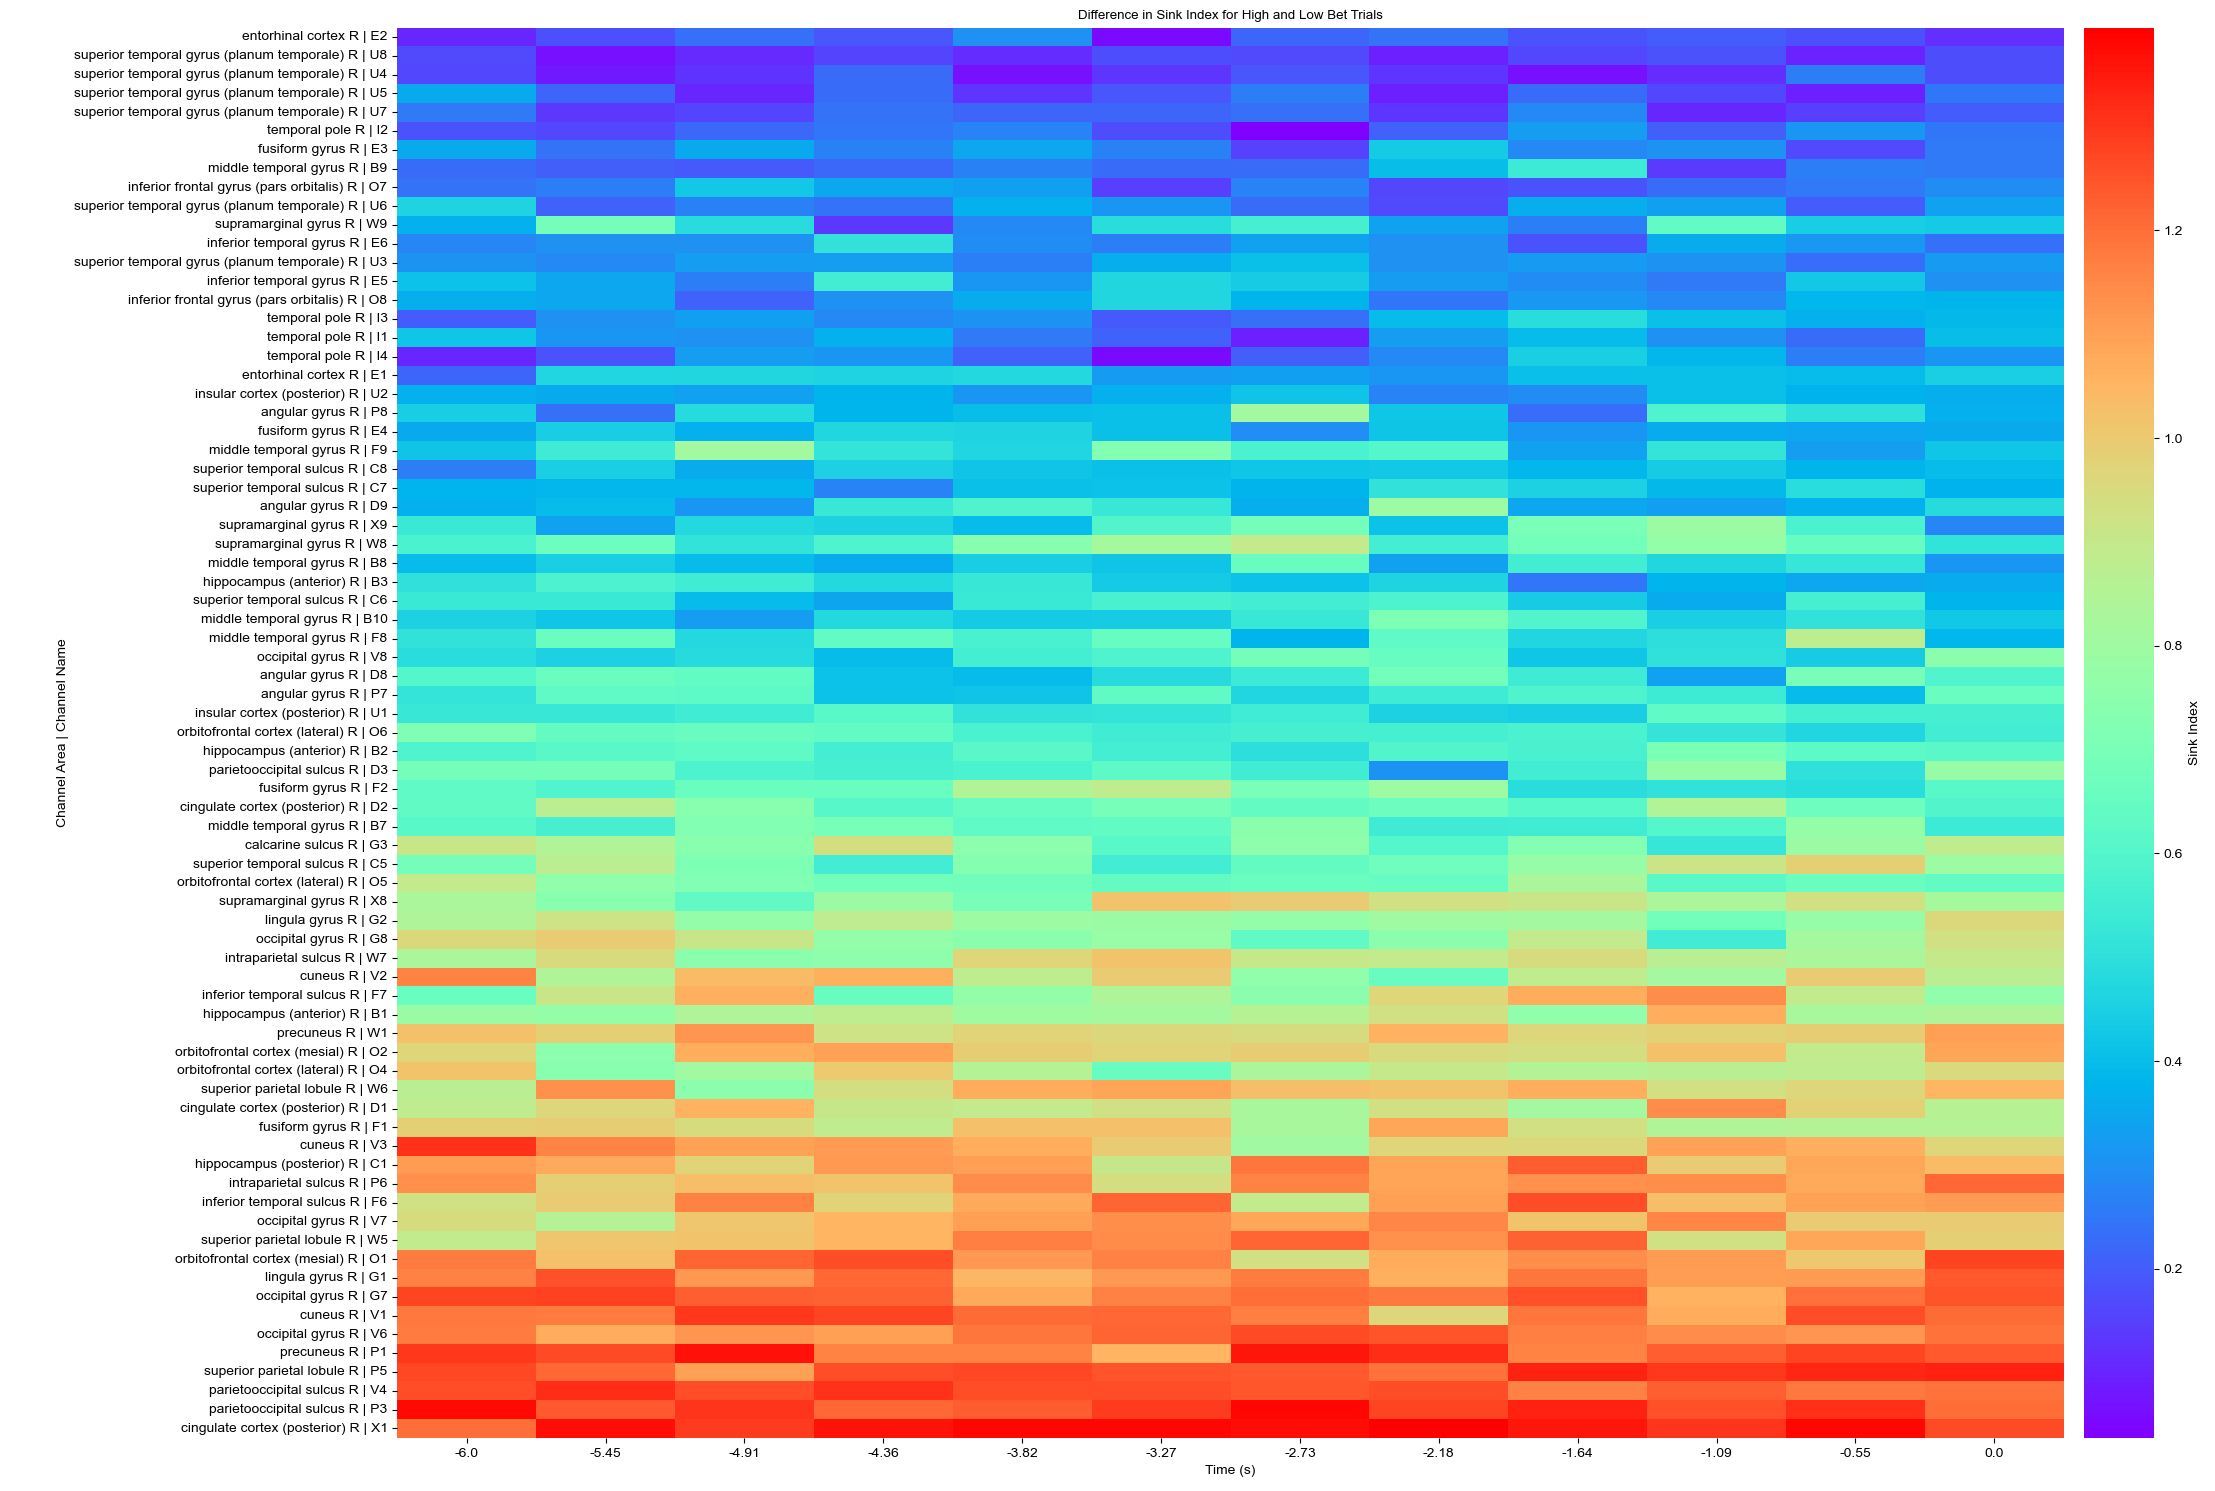

In [25]:
dsFs = 500
window_length = snapshot.shape[2]/dsFs
num_timesteps = A_hat_all_trials.shape[3]
onset_delay = 6
time = np.linspace(0,window_length,num_timesteps) - onset_delay
time = [round(i, 2) for i in time]
fs = 500
winSize_sec = 0.5

winSize = winSize_sec*fs

ss.plot_SI_heatmap(A_hat_all_trials, SI_wins_all_trials[0], winSize, fs, time)